# **Spit some [tensor] flow**

We need to learn the intricacies of tensorflow to master deep learning

Reference: https://www.tensorflow.org/tutorials



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
import sys, os


In [0]:
from tensorflow.keras.applications.vgg16 import VGG16 as pretrained, preprocess_input

In [0]:
url = 'https://thestandom.com/wp-content/uploads/2019/11/mamamoo-hip-comeback.jpg'

In [0]:
import IPython.display as display
from PIL import Image
import PIL

In [6]:
base_model = pretrained(include_top=False, weights='imagenet')

58892288/58889256 [==============================] - 1s 0us/step


In [7]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [0]:
#layers = [base_model.get_layer(name).output for name in names] 
layers = [base_model.get_layer('block1_conv1').output]
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [9]:
print(layers)

[<tf.Tensor 'block1_conv1/Identity:0' shape=(None, None, None, 64) dtype=float32>]


In [0]:
def get_image(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)


In [12]:
sample_image = get_image(url, 500)

81920/74784 [================================] - 0s 0us/step


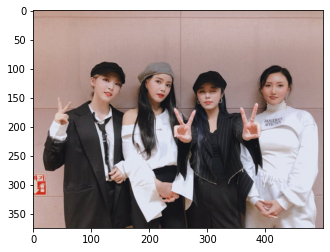

In [13]:
plt.imshow(sample_image)

In [0]:
sample_image = np.array(sample_image)/255.0
sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)

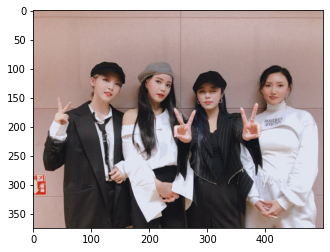

In [15]:
plt.imshow(sample_image)

In [0]:
sample_image = tf.Variable(preprocess_input(sample_image))

In [17]:
sample_image.shape

TensorShape([375, 500, 3])

In [0]:
img_batch = tf.expand_dims(sample_image, axis=0)

In [19]:
img_batch.shape

TensorShape([1, 375, 500, 3])

In [0]:
activations = dream_model.predict(img_batch)

In [0]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)



In [22]:
loss = calc_loss(sample_image, dream_model)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=21.349726>

In [0]:
def deprocess(image):
  image = 255*(image + 1.0)/2.0
  return tf.cast(image, tf.uint8)

In [0]:
# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))
  #plt.imshow(img)


In [0]:
def deepdream(model,img, run_steps,step_size):
    print("Tracing")
    loss = tf.constant(0.0)
    for n in tf.range(run_steps):
      with tf.GradientTape() as tape:
        # This needs gradients relative to `img`
        # `GradientTape` only watches `tf.Variable`s by default
        tape.watch(img)
        loss = calc_loss(img, model)

      # Calculate the gradient of the loss with respect to the pixels of the input image.
      gradients = tape.gradient(loss, img)

      # Normalize the gradients.
      gradients /= tf.math.reduce_std(gradients) + 1e-8 
      
      # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
      # You can update the image by directly adding the gradients
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

    return loss, img

In [0]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(dream_model, img, run_steps, tf.constant(step_size))
    #display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  #display.clear_output(wait=True)
  show(result)

  return result

Tracing


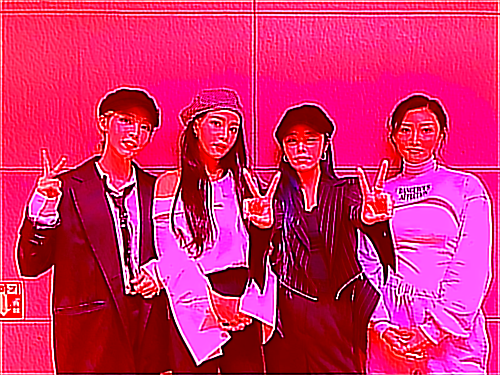

Step 100, loss 0.8859844207763672
Tracing


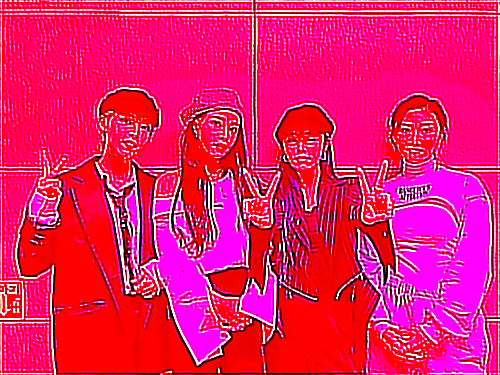

Step 200, loss 1.0151859521865845
Tracing


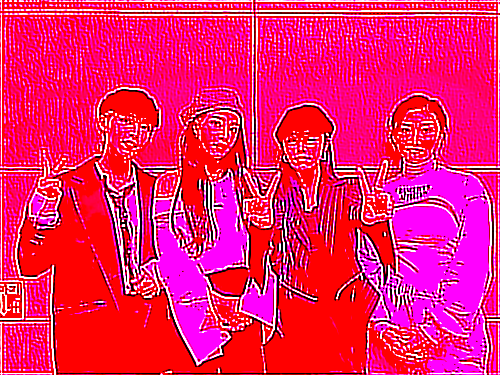

Step 300, loss 1.0432305335998535


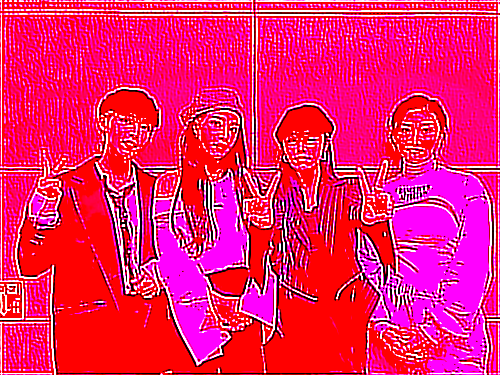

In [27]:
sample_image = get_image(url, 500)
dream_img = run_deep_dream_simple(img=sample_image, steps=300, step_size=0.01)


Tracing


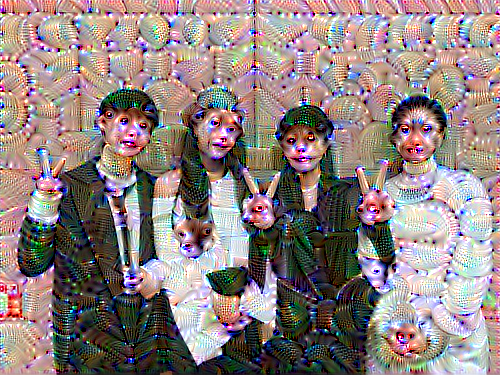

Step 100, loss 3.603139638900757
Tracing


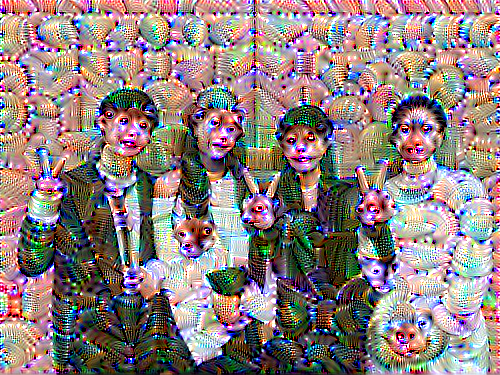

Step 200, loss 4.4273905754089355
Tracing


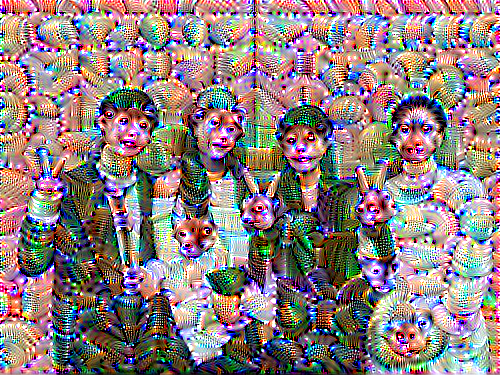

Step 300, loss 4.831806659698486


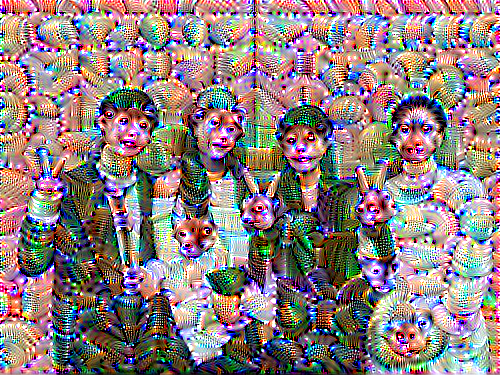

In [28]:
layers = [base_model.get_layer('block5_conv1').output]
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)
dream_img = run_deep_dream_simple(img=sample_image, steps=300, step_size=0.01)